<h1> Pnuemonia Detection using VGG16 Architecture

In [13]:
# Import Libraries

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
import numpy as np
import keras
from glob import glob
import os
import pandas as pd
from keras.layers import Dropout
import matplotlib.pyplot as plt

In [3]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [ ]:

model = Sequential()

model.add(vgg)

#fully connected layer
model.add(Flatten())

model.add(Dense(4096))
model.add(Dropout(0.5))


model.add(Dense(4096))
model.add(Dropout(0.5))

model.add(Dense(2, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8

In [ ]:
# Compile model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
#Add checkpoints 
from keras.callbacks import ModelCheckpoint, EarlyStopping
#filepath='saved_models/models.h5'
#filepath="saved_models/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5" #File name includes epoch and validation accuracy.
filepath="/content/drive/MyDrive/Deep Learning/Pnuemonia Detection Project/Best_model_Vgg16.hdf5" #File name includes epoch and validation accuracy.

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1)

callbacks_list = [checkpoint]

In [26]:
# Fitting the CNN to the images

from keras.preprocessing.image import ImageDataGenerator

# Generating train and test Dataset
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

# File path
path1 = '/content/drive/MyDrive/Deep Learning/Pnuemonia Detection Project/Data/train'
path2 = '/content/drive/MyDrive/Deep Learning/Pnuemonia Detection Project/Data/test'

# Procesing images before training 
training_set = train_datagen.flow_from_directory(path1,
                                                 target_size = (224, 224),
                                                 batch_size =32 ,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(path2,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Model Fit
history = model.fit_generator(training_set,
                         steps_per_epoch = 163,
                         epochs = 20,
                         validation_data = test_set,    
                         validation_steps = 19,callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
163/163 [==============================] - 1687s 10s/step - loss: 93.8000 - accuracy: 0.7688 - val_loss: 2.6051 - val_accuracy: 0.8487
Epoch 2/20
163/163 [==============================] - 110s 677ms/step - loss: 1.3149 - accuracy: 0.9170 - val_loss: 2.4181 - val_accuracy: 0.8882
Epoch 3/20
163/163 [==============================] - 110s 678ms/step - loss: 0.7275 - accuracy: 0.9330 - val_loss: 1.2965 - val_accuracy: 0.9095
Epoch 4/20
163/163 [==============================] - 108s 662ms/step - loss: 0.6393 - accuracy: 0.9464 - val_loss: 3.9065 - val_accuracy: 0.8602
Epoch 5/20
163/163 [==============================] - 108s 659ms/step - loss: 0.5498 - accuracy: 0.9479 - val_loss: 1.7638 - val_accuracy: 0.9062
Epoch 6/20
163/163 [==============================] - 107s 657ms/step - loss: 0.4859 - accuracy: 0.9495 - val_loss: 1.6679 - val_accuracy: 0.8980
Epoch 7/20
163/163 [==============================] - 107s 653ms/step - loss: 0.4838 - accuracy: 0.9521 - val_loss: 1.7423 -

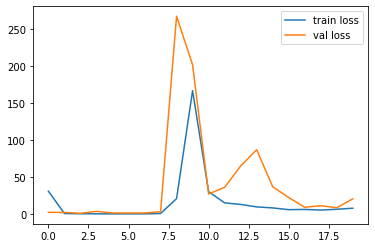

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Deep Learning/Pnuemonia Detection Project/LossVal_loss_Vgg16')

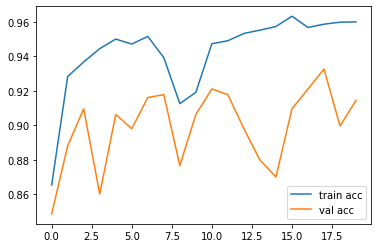

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Deep Learning/Pnuemonia Detection Project/AccVal_acc_vgg16')

In [ ]:
# Save Model
model.save('/content/drive/MyDrive/Deep Learning/Pnuemonia Detection Project/vgg16_model.h5')

In [16]:
# Creating a label file of test data

import cv2
def picture_separation(folder):
  '''divide the mixed pictures into NORMAL and PNEUMONIA & add labels to these'''
  X = []
  y = []
  image_list = []

  for foldername in os.listdir(folder):
    if not foldername.startswith('.'):
      if foldername == "NORMAL":
        label = 0
      elif foldername == "PNEUMONIA":
        label = 1
      else:
        label = 2
      
      for image_filename in os.listdir(folder + "/"+ foldername):
        img_file = cv2.imread(folder + "/" + foldername + '/' + image_filename,1)
        if img_file is not None:
          img = cv2.resize(img_file,(224,224))
          img_arr = img_to_array(img) / 255
          X.append(img_arr)
          y.append(label)
          image_list.append(foldername + '/' + image_filename)
                                        
  X = np.asarray(X)
  y = np.asarray(y)
    
  return X, y, image_list

In [17]:
# get test dataset with labels
X_test, y_test, img_test = picture_separation('/content/drive/MyDrive/Deep Learning/Pnuemonia Detection Project/Data/test/')

test_df = pd.DataFrame(img_test, columns = ["images"])
test_df["target"] = y_test

#preview
test_df.head()

,images,target
0,PNEUMONIA/person100_bacteria_480.jpeg,1
1,PNEUMONIA/person100_bacteria_478.jpeg,1
2,PNEUMONIA/person101_bacteria_483.jpeg,1
3,PNEUMONIA/person100_bacteria_475.jpeg,1
4,PNEUMONIA/person100_bacteria_481.jpeg,1


In [18]:
# Load Model
model = keras.models.load_model('/content/drive/MyDrive/Deep Learning/Pnuemonia Detection Project/vgg16_model.h5')

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

#make prediction
yhat_test = model.predict_classes(X_test)

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[205  29]
 [ 23 367]]


In [20]:
# Visualize Confusion Matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(b = None)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

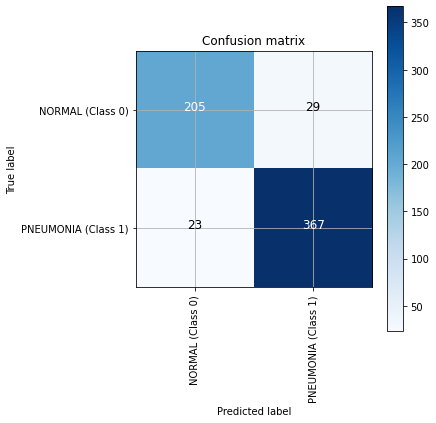

In [21]:
#plot confustion matrix
plot_confusion_matrix(cm, classes = ['NORMAL (Class 0)','PNEUMONIA (Class 1)'], normalize = False)

In [34]:
# Classification report to evaluate other metrics

from sklearn.metrics import classification_report

print('VGG16 Architecture', '\n', classification_report(y_test, yhat_test, target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

VGG16 Architecture 
                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.90      0.88      0.89       234
PNEUMONIA (Class 1)       0.93      0.94      0.93       390

           accuracy                           0.92       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



AUC: 0.9085470085470085


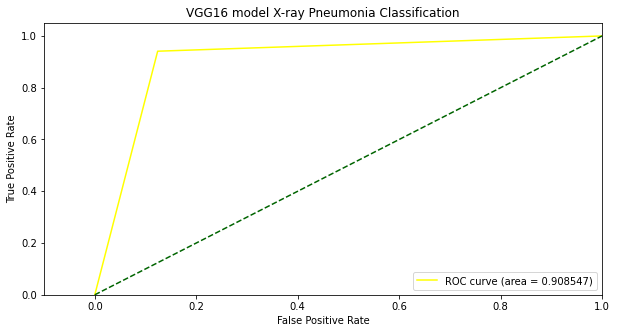

In [33]:
# ROC and AUC curve to evaluate model

from sklearn.metrics import auc,roc_curve,roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, yhat_test)
auc = roc_auc_score(y_test, yhat_test)
print('AUC:', auc)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 model X-ray Pneumonia Classification')
plt.legend(loc = "lower right")
plt.show()

In [32]:
# Testing image

import numpy as np
from keras.preprocessing import image
path3 = '/content/drive/MyDrive/Deep Learning/Pnuemonia Detection Project/Data/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'
test_image = image.load_img(path3, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'PNEUMONIA'
    print(prediction)
else:
    prediction = 'NORMAL'
    print(prediction)

NORMAL


<h3><b>Model is performing better than basic model (recall increased to 89 and 93). There are less misclassifications than basic. However, we can try other transfer learning technique and check whether the performance increases or not. Next, I will be implementing RESNET architecture. 